# Quick Tour

---

This is a quick tour of `pybuck`---a package to support dimensional analysis in Python.

## Basic Dimensional Analysis

First we demonstrate some basic tasks in dimensional analysis; the `pybuck` package automates many basic computations.

In [1]:
import grama as gr

from pybuck import *
from plotnine import *

DF = gr.Intention()

We are studying the *Reynolds' pipe flow problem* [1], which has physical inputs:

| Input | Symbol | Units |
|--|--|--|
| Fluid density | $\rho$ | $\frac{M}{L^3}$ |
| Fluid bulk velocity | $U$ | $\frac{L}{T}$ |
| Pipe diameter | $D$ | $L$ |
| Fluid dynamic viscosity | $\mu$ | $\frac{M}{LT}$ |
| Roughness lengthscale | $\epsilon$ | $L$ |

We construct the *dimension matrix* [2] with compact syntax. Zeros are automatically filled in.

In [2]:
df_dim = col_matrix(
    rho = dict(M=1, L=-3),
    U   = dict(L=1, T=-1),
    D   = dict(L=1),
    mu  = dict(M=1, L=-1, T=-1),
    eps = dict(L=1)
)
df_dim


,rowname,rho,U,D,mu,eps
0,L,-3,1,1,-1,1
1,T,0,-1,0,-1,0
2,M,1,0,0,1,0


This is a standardized way to represent the physical units of the inputs. We can check the physical units of a power-product of the inputs above through an inner product. Note that $\frac{1}{2}\rho U^2$ is *dynamic pressure*, so it should have the units of pressure $\left[\frac{M}{LT^2}\right]$. Dimensionless constants are ignored when performing dimensional analysis.

In [3]:
df_weights = col_matrix(q = dict(rho=1, U=2))
df_res = inner(df_dim, df_weights)
df_res


,rowname,q
0,L,-1
1,T,-2
2,M,1


We can compute a basis for the nullspace of `df_dim`; this subspace is called the *pi subspace*.

In [4]:
df_pi = pi_basis(df_dim)
df_pi


,rowname,pi0,pi1
0,rho,-0.521959,0.115207
1,U,-0.521959,0.115207
2,D,-0.413385,-0.632884
3,mu,0.521959,-0.115207
4,eps,-0.108575,0.748091


This shows us that the pi subspace is two-dimensional. The weights are fairly non-standard; a more familiar set are the *Reynolds number* and the *relative roughness*.

In [5]:
df_standard = col_matrix(
    Re = dict(rho=1, U=1, D=1, mu=-1), # Reynolds number
    R  = dict(eps=1, D=-1)             # Relative roughness
)
df_standard


,rowname,Re,R
0,mu,-1,0
1,eps,0,1
2,D,1,-1
3,rho,1,0
4,U,1,0


We can check that these two bases are the same by computing the *subspace angles* between them:

In [6]:
angles(df_standard, df_pi)

array([4.51334311e-16, 1.74062712e-16])

All subspace angles are zero to working precision; these two bases express the same subspace.

Since these are the same subspace, we can re-express the computed basis `df_pi` in terms of the standard basis `df_standard`. This will allow us to physically interpret the computationally-derived weights.

In [7]:
df_pi_prime = express(df_pi, df_standard)
df_pi_prime


,rowname,pi0,pi1
0,Re,-0.521959,0.115207
1,R,-0.108575,0.748091


This shows us that `pi0` is composed of both `Re` and `R`, while `pi1` is almost entirely aligned with `R`.

We can non-dimensionalize target quantities by providing their physical dimensions. If we wanted to non-dimensionalize a flow rate $[Q] = \frac{M}{L^3 T}$, we could produce the *canonical non-dimensionalizing factor* [2] via

In [8]:
df_flowrate = col_matrix(pi_Q = dict(M=+1, L=-3, T=-1))
df_nondim = nondim(df_flowrate, df_dim)
print(inner(df_dim, df_nondim))
df_nondim


  rowname  pi_Q
0       L   3.0
1       T   1.0
2       M  -1.0


,rowname,pi_Q
0,rho,-0.571429
1,U,-0.571429
2,D,0.714286
3,mu,-0.428571
4,eps,0.714286


Note that the canonical factor has the *opposite* physical units of what we coded above; this is because multiplying by this factor should *cancel* the physical units of our target quantity, leading to a dimensionless number.

The canonical factor is also orthogonal to the pi subspace. We can verify orthogonality computing the subspace angles.

In [9]:
angles(df_nondim, df_pi)

array([1.57079633])

This is $90^{\circ}$; orthogonal to the pi subspace.

We can verify that `df_nondim` non-dimensionalizes the qoi correctly by *augmenting* the dimension matrix and non-dimensionalizing vector with $Q$, then carrying out an inner product. If $Q \times \exp(

In [10]:
df_dim_ext = add_col(df_dim, Q=dict(M=1, L=-3, T=-1))
print(df_dim_ext)
df_nondim_ext = add_row(df_nondim, Q=[1])
print(df_nondim_ext)

inner(df_dim_ext, df_nondim_ext)

  rowname  rho  U  D  mu  eps  Q
0       L   -3  1  1  -1    1 -3
1       T    0 -1  0  -1    0 -1
2       M    1  0  0   1    0  1
  rowname      pi_Q
0       D  0.714286
1       Q  1.000000
2       U -0.571429
3     eps  0.714286
4      mu -0.428571
5     rho -0.571429


,rowname,pi_Q
0,L,0.000000e+00
1,T,-6.661338e-16
2,M,4.440892e-16


## Empirical Dimension Reduction

Next we demonstrate combining *empirical dimension reduction* with dimensional analysis. This allows one to equip data-driven methods with physical interpretation.

First, we generate some data for the Reynolds pipe flow problem. This follows the setup described in Reference 2.

In [11]:
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from model_pipe import fcn

## Simulate collecting data
np.random.seed(101)
n_data = 500

Q_names = ["rho", "U", "D", "mu", "eps"]
Q_lo = np.array([1.0, 1.0e+0, 1.3, 1.0e-5, 0.5e-1])
Q_hi = np.array([1.4, 1.0e+1, 1.7, 1.5e-5, 4.0e-1])
Q_all = np.random.random((n_data, len(Q_lo))) * (Q_hi - Q_lo) + Q_lo

F_all = np.zeros(n_data)
for i in range(n_data):
    res = fcn(Q_all[i])
    F_all[i] = res

df_data = pd.DataFrame(
    data=Q_all,
    index=range(n_data),
    columns=Q_names
)
df_data["f"] = F_all
df_data


,rho,U,D,mu,eps,f
0,1.206559,6.136008,1.311390,0.000011,0.289847,0.170242
1,1.333559,3.762696,1.657445,0.000014,0.116479,0.085578
2,1.221691,4.169188,1.372757,0.000014,0.387919,0.204711
3,1.092941,1.752053,1.541419,0.000014,0.146684,0.100495
4,1.274123,5.660807,1.319394,0.000011,0.115439,0.095950
...,...,...,...,...,...,...
495,1.075016,9.246646,1.401458,0.000013,0.128325,0.098339
496,1.280810,2.387921,1.335002,0.000014,0.298925,0.171866
497,1.263388,5.166624,1.508881,0.000013,0.342431,0.173515
498,1.272550,5.500882,1.534153,0.000013,0.347752,0.173365


To perform empirical dimension reduction, we will carry out ordinary least squares to regress the output `f` on the inputs `rho, U, D, mu, eps`. However, if we **log transform** our inputs, any *linear* dimension reduction can be interpreted as a product of the inputs [2]. This will allow us to combine dimension reduction with dimensional analysis. To illustrate:

In [12]:
df_log = df_data.copy()
df_log[Q_names] = np.log(df_log[Q_names])
df_log

lm = smf.ols(
    "f ~ rho + U + D + mu + eps",
    data=df_log
).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      f   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     1662.
Date:                Wed, 07 Jul 2021   Prob (F-statistic):          2.78e-306
Time:                        08:31:10   Log-Likelihood:                 1641.5
No. Observations:                 500   AIC:                            -3271.
Df Residuals:                     494   BIC:                            -3246.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2707      0.040      6.791      0.000       0.192       0.349
rho            0.0005      0.004      0.106      0.915      -0.008       0.009
U             -0.0007      0.001     -1.075      0.283      -0.002       0.001
D             -0.0830      0.005    -15.564      0.000      -0.093      -0.072
mu            -0.0006      0.004     -0.181      0.856      -0.008       0.006
eps            0.0695      0.001     89.250      0.000       0.068       0.071
==============================================================================
Omnibus:                       55.973   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.840
Skew:                           0.931   Prob(JB):                     1.52e-16
Kurtosis:                       3.179   Cond. No.                     1.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The regression diagnostics above indicate that the fit is quite accurate with an $R^2 = 0.98$. Next we extract the regression coefficients and package them for `pybuck` with the following recipe.

In [13]:
df_dr = pd.DataFrame({
    "rowname": lm.params.index[1:],
    "pi": lm.params.values[1:]
})
df_dr = normalize(df_dr)


We can check the physical units of this proposed direction. This is a diagnostic quantity; if things go wrong, it will help us determine how they went wrong (as we'll see in the example below).

In [14]:
inner(df_dim, df_dr)

,rowname,pi
0,L,-0.137704
1,T,0.012671
2,M,-0.001626


This is very nearly dimensionless, which doesn't indicate any issues with lurking variables. 

We can re-express this number in terms of our standard basis.

In [15]:
express(df_dr, df_standard)

,rowname,pi
0,Re,-0.016768
1,R,0.695963


Re-expression reveals that the empirical dimension reduction has recovered the relative roughness `R`, which fully describes the output variation in the setting considered.

### ASIDE:


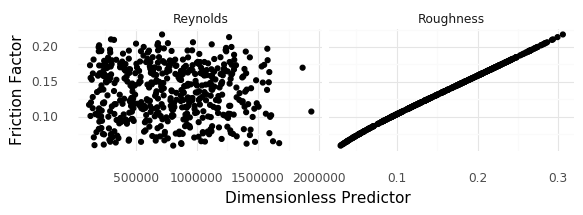

<ggplot: (8782841212621)>

In [16]:
(
    df_data
    >> gr.tf_mutate(
        Reynolds=DF.rho * DF.U * DF.D / DF.mu,
        Roughness=DF.eps / DF.D,
    )
    
    >> gr.tf_gather(
        "pi",
        "xi",
        ["Reynolds", "Roughness"]
    )
    
    >> ggplot(aes("xi", "f"))
    + geom_point()
    
    + facet_grid("~pi", scales="free_x")
    + theme_minimal()
    + theme(aspect_ratio=1/2)
    + labs(
        x="Dimensionless Predictor",
        y="Friction Factor"
    )
)

## Lurking Variable Detection

Finally, we slightly modify the problem above to demonstrate *lurking variable detection*.

Suppose that during data collection we did not know that `eps` is a physical input. In this case, we would not know to vary it in our experiments, and it might remain fixed to an unknown value. To model this, we fix `eps=0.1` in data generation.

In [17]:
## Generate frozen-eps data
Fp_all = np.zeros(n_data)
Qp_all = Q_all
Qp_all[:, 4] = [0.1] * n_data

for i in range(n_data):
    Fp_all[i] = fcn(Qp_all[i])

df_frz = pd.DataFrame(
    data=Qp_all,
    index=range(n_data),
    columns=Q_names
)
df_frz["f"] = Fp_all
df_frz


,rho,U,D,mu,eps,f
0,1.206559,6.136008,1.311390,0.000011,0.1,0.089230
1,1.333559,3.762696,1.657445,0.000014,0.1,0.079317
2,1.221691,4.169188,1.372757,0.000014,0.1,0.087167
3,1.092941,1.752053,1.541419,0.000014,0.1,0.082266
4,1.274123,5.660807,1.319394,0.000011,0.1,0.088949
...,...,...,...,...,...,...
495,1.075016,9.246646,1.401458,0.000013,0.1,0.086231
496,1.280810,2.387921,1.335002,0.000014,0.1,0.088452
497,1.263388,5.166624,1.508881,0.000013,0.1,0.083080
498,1.272550,5.500882,1.534153,0.000013,0.1,0.082392


We repeat computing a linear dimension reduction on the frozen data.

In [18]:
df_frz_log = df_data.copy()
df_frz_log[Q_names] = np.log(df_frz_log[Q_names])
df_frz_log

lm_frz = smf.ols(
    "f ~ rho + U + D + mu",
    data=df_frz_log
).fit()

df_frz_dr = pd.DataFrame({
    "rowname": lm_frz.params.index[1:],
    "pi": lm_frz.params.values[1:]
})
df_frz_dr = normalize(df_frz_dr)
print(transpose(df_frz_dr))

  rowname         D         U        mu       rho
0      pi -0.992725  0.006045 -0.119729  0.011206


Let's inspect the physical dimensions of `df_frz_dr`.

In [19]:
print(inner(df_dim, df_frz_dr))

  rowname        pi
0       L -0.900568
1       T  0.113684
2       M -0.108523


This direction is not dimensionless! This indicates that a lurking variable is present, and it has units of `L`. This procedure has correctly identified the presence of our lurking variable `eps` which has dimensions $[\epsilon] = L$. 

# Bibliography

---

[1] O. Reynolds, "An experimental investigation of the circumstances which determine whether the motion of water shall be direct or sinuous, and of the law of resistance in parallel channels" (1883) *Royal Society*

[2] Z. del Rosario, M. Lee, and G. Iaccarino, "Lurking Variable Detection via Dimensional Analysis" (2019) *SIAM/ASA Journal on Uncertainty Quantification*